In [206]:
!pip install afinn
!pip install nltk

In [207]:
from afinn import Afinn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from datetime import datetime as dt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

import seaborn as sns
import nltk
import pandas as pd
import math, re, numpy as np, os

In [208]:
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [209]:
RES_FILE_TEST = "Results/result_sp_test_dataset.csv"
RES_FILE_WHOLE = "Results/result_sp_whole_dataset.csv"
AFFIN_VS_SPIVOT_COMPARISON_FILE = "Results/affin_vs_sp_comparison.csv"
AFFIN_VS_SPIVOT_ACCURACY_FILE = "Results/affin_vs_sp_accuracy.csv"
AFF_RES = "Results/result_affin_whole_dataset.csv"
MODEL_COMPARISONS_FILE = "Results/model_comparisons.csv"
MODEL_ACCURACY_FILE = "Results/model_accuracy.csv"
SENTIMENTS_DICT = {1:"Positive", 0:"Neutral", -1:"Negative"}
LOG_HEADERS = ["Tokenized Words", "Sentiment Scores", "Skip Conquer", "Chosen Pivot", "Simplified Zeroes", 
               "First", "Mid", "Last",  "Pivot Sentiments",
               "Final Sentiment", ]
SENTI_PIVOT = "SentiPivot"
SCORE_AVERAGING = "macro"
RAND_STATE  = 11
AFF = Afinn(language="en")

In [210]:
VISUAL_PALETTE = sns.color_palette("muted", 5)
VISUAL_PALETTE

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765)]

In [211]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 13

In [212]:
if not os.path.exists("Results"):
    os.mkdir("Results")

## Load data

In [213]:
df = pd.read_csv(r"Covid-19-tweets.csv")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

#  Make sentiments = 1, 0, -1
replace_sentiments_dict = {val:key for key,val in SENTIMENTS_DICT.items()}
df["sentiment"].replace(replace_sentiments_dict, inplace=True)
df.head()

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,1
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,1
4,"Me, ready to go at supermarket during the #COV...",-1


In [214]:
# Split to train and test set
X = df["text"]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RAND_STATE)

## Prepare the SentiPivot inputs

In [215]:
def preprocess(doc):
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer(language="english")
    stopw = stopwords.words('english')
     
    # ensure that the only whitespace present is a single space 
    doc = re.sub(r"\s+",repl=" ", string=doc)
    
    # handle apostrophes in words since
    # it will be removed on the next steps
    # eg. hadn't, didn't
    tokenized = []
    for a in doc.split():
        if re.findall(r"\w+'\w*", a):
            a = re.sub("'", repl="", string=a)
        tokenized.append(a)
    doc = " ".join(tokenized)
    
    # remove urls and emails
    doc =  re.sub(r"(http\S+)|(\w+@\w+\.com)", repl= "", string=doc)
    
    # remove mentions and hashtag
    doc =  re.sub(r"(@|#)\s*\S+", repl= "", string=doc)
    
    # remove non alpha
    doc = re.sub(r"[^A-Za-z\s]", repl=" ", string=doc)
    
    # lemmatized and stemmed
    transformed = []
    for tagged in nltk.pos_tag(doc.split()):
        word = tagged[0]
        tag = tagged[1]
        
        # For example we don;t want to stem
        # words such as nothing, flying, and earthling
        # Pos Tags = https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/
        if tag in ["RB", "VBG", "VBN", "VBD", "JJ"]:
            stemmed = stemmer.stem(word)
            if stemmed.endswith("i"):
                stemmed = word
            word = stemmed
            
        if word not in ["has", "was"]:
            word = lemmatizer.lemmatize(word)
                 
        word = word.lower()
        transformed.append(word)
        
    doc = " ".join(transformed)
    
    # remove stop words
    for stop in stopw:
        doc = re.sub(r"\b{}\b".format(stop), repl="", string=doc)
    
    # ensure that the only whitespace present is a single space 
    doc = re.sub(r"\s+",repl=" ", string=doc)
    
    return doc.strip()

In [216]:
print("For testing purposes ...\n")
print(preprocess("He cared for me nicely"))
print(preprocess("didn't has The dog --- is barking and ..43.4 34. 423"))
print(preprocess("llll'kkaka The #jajaja @cat dog --- is barking and ..43.4 34. 423"))
print(preprocess("The #jajaja @cat dog @aa222--- is barking and ..43.4 34. https://www.facebook.com/423"))
print(preprocess("I am caring person"))
print(preprocess("The beauty in her eyes"))
print(preprocess("Here goes nothing"))
print(preprocess("The flying pig"))

For testing purposes ...

care nice
didnt dog bark
llllkkaka dog bark
dog bark
care person
beauty eye
go nothing
flying pig


In [217]:
def prepare_senti_pivot_input(X,y):
    tokenized = []
    sentiment_scores = []
    sentiments_true = []
    
    # convert data to sentiment scores using Affin
    for index,text in enumerate(list(X)):
        sentiment = list(y)[index]

        cleaned = preprocess(text)

        # get the sentiment scores for each word
        scores = []
        for word in cleaned.split():
            scores.append(int(AFF.score(word)))

        # prevent empty data from cleaning
        # cleaning may produce empty data since it remove words
        if len(scores) != 0:
            sentiment_scores.append(scores) 
            sentiments_true.append(sentiment)
            tokenized.append(cleaned)
    return tokenized, sentiment_scores, sentiments_true

In [218]:
print("Preparing input for train dataset")
tokenized_train, sentiment_scores_train, sentiments_true_train = prepare_senti_pivot_input(X_train, y_train)
print("Train dataset has",len(tokenized_train) , "rows")

Preparing input for train dataset
Train dataset has 31425 rows


In [219]:
print("Preparing input for test dataset")
tokenized_test, sentiment_scores_test, sentiments_true_test = prepare_senti_pivot_input(X_test, y_test)
print("Train dataset has",len(tokenized_test) , "rows")

Preparing input for test dataset
Train dataset has 13473 rows


In [220]:
print("Preparing input for whole dataset")
tokenized_whole, sentiment_scores_whole, sentiments_true_whole = [], [], []

tokenized_whole.extend(tokenized_train)
tokenized_whole.extend(tokenized_test)

sentiment_scores_whole.extend(sentiment_scores_train)
sentiment_scores_whole.extend(sentiment_scores_test)

sentiments_true_whole.extend(sentiments_true_train)
sentiments_true_whole.extend(sentiments_true_test)

print("Whole dataset has", len(tokenized_whole) , "rows")

Preparing input for whole dataset
Whole dataset has 44898 rows


## Visualization

Whole Dataset


<AxesSubplot:ylabel='sentiments'>

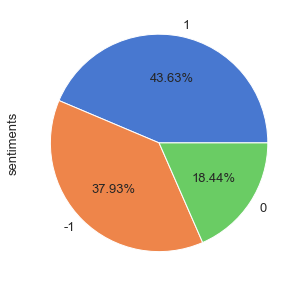

In [221]:
print("Whole Dataset")
pd.DataFrame({"sentiments":sentiments_true_whole})["sentiments"].value_counts().plot.pie(autopct="%.2f%%",colors=VISUAL_PALETTE)

Train Dataset


<AxesSubplot:ylabel='sentiments'>

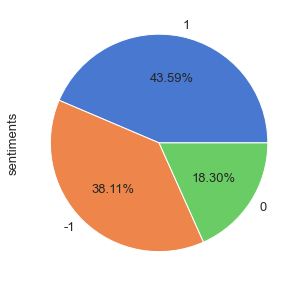

In [222]:
print("Train Dataset")
pd.DataFrame({"sentiments":sentiments_true_train})["sentiments"].value_counts().plot.pie(autopct="%.2f%%",colors=VISUAL_PALETTE)

Test Dataset


<AxesSubplot:ylabel='sentiments'>

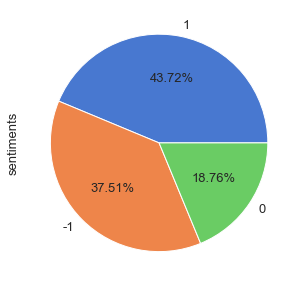

In [223]:
print("Test Dataset")
pd.DataFrame({"sentiments":sentiments_true_test})["sentiments"].value_counts().plot.pie(autopct="%.2f%%", colors=VISUAL_PALETTE)

## Senti Pivot Classification

In [224]:
def create_pivot(scores):
    pivot_index_dict = {}
    pivot_index_dict["first"] = 0
    pivot_index_dict["mid"] = int(len(scores)/2)
    pivot_index_dict["last"] = len(scores)-1
    return pivot_index_dict

In [225]:
def manage_zeroes(pivot_index_dict, scores):
    managed_scores = scores.copy()
    for index,score in enumerate(scores):
        # Make non pivot 0 = None
        if score == 0 and index not in list(pivot_index_dict.values()):
            managed_scores[index] = None
            
    # Ensures that there will be always one 0 remaining if
    # there are 0s in the original scores
    if None in scores and 0 not in scores:
        # make the first None value = 0
        scores[scores.index(None)] = 0
    
    return managed_scores

In [226]:
# 0 - neutral, 1- positive, -1 - negative
def convert_to_numerical_sentiment(inp):
    val = 0
    if inp > 0:
        val = 1
    elif inp < 0:
        val = -1
        
    return val

In [227]:
def segregate(scores, pivot_index, pivot_value): 
    # will store left and right values
    left = []
    right = []

    # segregate to left or right
    for index,score in enumerate(scores):
        if score != None:
            # don't include pivot in the segregation
            if index != pivot_index:

                # greater value than pivot = right, else = left
                if score > pivot_value:
                    right.append(score)
                elif score < pivot_value:
                    left.append(score)

                # If score same value as the current pivot, 
                # execute the rules in number 2 sa document
                elif score < 0:
                    left.append(score)
                elif score > 0:
                    right.append(score)
                    
    return left, right

In [228]:
def sentiPivot(pivot_index_dict, scores):
    conquering_skipped = False
    results = []
    processes = {}
    
    # Number 6, bullet 1,2,3
    if len(set(scores)) == 1:
        val = convert_to_numerical_sentiment(scores[0])
        results.append(val)
        processes["Skip Conquer"] = "All scores are {}".format(SENTIMENTS_DICT[val])
        conquering_skipped = True
    
    else:
        # convert pos to 1 , and negatives to -1
        zero_ones_neg_ones = [0 if s is None or s == 0 else (-1 if s < 0 else 1) for s in scores]
        
        # Number 6, bullet 3, sub bullet 1 and 2
        if len(set(zero_ones_neg_ones)) <= 2 and 0 in scores:
            score_sum = sum(zero_ones_neg_ones)
            val = convert_to_numerical_sentiment(score_sum)
            results.append(val)
            processes["Skip Conquer"] = "Sentiment scores are only Neutral and {}".format(SENTIMENTS_DICT[val])
            conquering_skipped = True
            
        # do conquering
        else:
            processes["Skip Conquer"] = "Positive, negative and neutral are all present proceed to SentiPivot algorithm"

            # converting arrays to list to add commas when converting to string
            processes["Chosen Pivot"] = list(np.array(scores)[list(pivot_index_dict.values())])

            # remove the word "None" produce from managing zeroes
            processes["Simplified Zeroes"] = re.sub("\\b, None\\b", "", str(scores))



            # Iterate the  pivots
            for pivot_name in pivot_index_dict.keys():
                pivot_index = pivot_index_dict[pivot_name]
                pivot_value = scores[pivot_index]

                # Store left and right values
                left, right = segregate(scores=scores, pivot_index=pivot_index, pivot_value= pivot_value)

                processes[pivot_name.capitalize()] = '{} "{}" {}'.format(left, pivot_value, right)

                # Determine the sentiment for the current pivot
                # 1= Positive, -1= Negative
                val = 0

                # by left and right length
                if len(left) > len(right):
                    val = -1
                elif len(left) < len(right):
                    val = 1

                # by left and right intensity
                elif abs(sum(left)) > abs(sum(right)):
                    val = -1
                elif abs(sum(left)) < abs(sum(right)):
                    val = 1

                results.append(val)

    return conquering_skipped, results, processes

In [229]:
def get_final_results(results):
    # The sum of the results is similar to the logic presented in No.5
    # Sa document na sinend mo sakin Freshten
    
    results_sum = sum(results)
    final_result = 0
    if results_sum > 0:
        final_result = 1
    elif results_sum < 0:
        final_result = -1
    return final_result

In [230]:
def to_millis(date):
    return int(date.timestamp() * 1000)

In [231]:
def classify(sentiment_scores, tokenized, log_file):
    sentiments_pred = []

    # the time (ms) it take to run the algorithm
    process_time = 0

    for index, raw_scores in enumerate(sentiment_scores):
        start_time = to_millis(dt.now())

        # Create pivot
        pivot_index_dict = create_pivot(raw_scores)

        # Manage all zeroes
        scores = manage_zeroes(pivot_index_dict, raw_scores)

        # get pivot results
        conquering_skipped, results, processes = sentiPivot(pivot_index_dict, scores)

        # get the final sentiment label
        sentiment = get_final_results(results)

        end_time = to_millis(dt.now())

        process_time+= (end_time - start_time)

        sentiments_pred.append(sentiment)

        processes["Sentiment Scores"] = raw_scores

        # add pivots when conquering
        if not conquering_skipped:
            processes["Pivot Sentiments"] = ", ".join([SENTIMENTS_DICT[res] for res in results])

        processes["Final Sentiment"] = SENTIMENTS_DICT[sentiment]

        processes["Tokenized Words"] = tokenized[index]

        # Record all process in a dictionary
        final_processes_dict = {}
        for header in LOG_HEADERS:
            data = []
            try:
                data.append( processes[header])
            except KeyError:
                data.append("skip")

            final_processes_dict[header] = data

        # save prpcesses as csv
        logs_df = pd.DataFrame(final_processes_dict)
        mode = 'a'
        header = False
        if index == 0:
            mode = 'w'
            header = True
        logs_df.to_csv(log_file, mode=mode, header=header, index=False)


    "Algorithm Processing Time: {} ms".format(process_time)
    return sentiments_pred

### Clear existing result files

In [232]:
if os.path.exists(RES_FILE_TEST):
    os.remove(RES_FILE_TEST)
    
if os.path.exists(RES_FILE_WHOLE):
    os.remove(RES_FILE_WHOLE)

### Do classification

In [233]:
print("Classifying Whole Dataset")
sentiments_pred_whole = classify(sentiment_scores_whole, tokenized_whole, RES_FILE_WHOLE)

Classifying Whole Dataset


In [234]:
print("Classifying Test Dataset")
sentiments_pred_test = classify(sentiment_scores_test, tokenized_test, RES_FILE_TEST)

Classifying Test Dataset


## Senti Pivot Results

In [235]:
print("Whole Dataset")
pd.read_csv(RES_FILE_WHOLE).head()

Whole Dataset


,Tokenized Words,Sentiment Scores,Skip Conquer,Chosen Pivot,Simplified Zeroes,First,Mid,Last,Pivot Sentiments,Final Sentiment
0,whenever come insid even walk grocery store,"[0, 0, 0, 0, 0, 0, 0]",Sentiment scores are only Neutral and Neutral,skip,skip,skip,skip,skip,skip,Neutral
1,case clean running water avail use hand saniti...,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0]","Positive, negative and neutral are all present...","[0, 0, 0]","[0, 2, 0, -2, 0]","[-2] ""0"" [2]","[-2] ""0"" [2]","[-2] ""0"" [2]","Neutral, Neutral, Neutral",Neutral
2,coronavirus florida miami dade reach case stat...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, -3, 0]","Positive, negative and neutral are all present...","[0, 0, 0]","[0, 1, 0, -3, 0]","[-3] ""0"" [1]","[-3] ""0"" [1]","[-3] ""0"" [1]","Negative, Negative, Negative",Negative
3,mention particular one cant remember name use ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Positive, negative and neutral are all present...","[0, 0, 1]","[0, 0, -2, 1]","[-2] ""0"" [1]","[-2] ""0"" [1]","[0, 0, -2] ""1"" []","Negative, Negative, Negative",Negative
4,alphabets drone delivery company wing see boom...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Sentiment scores are only Neutral and Neutral,skip,skip,skip,skip,skip,skip,Neutral


In [236]:
print("Test Dataset")
pd.read_csv(RES_FILE_TEST).head()

Test Dataset


,Tokenized Words,Sentiment Scores,Skip Conquer,Chosen Pivot,Simplified Zeroes,First,Mid,Last,Pivot Sentiments,Final Sentiment
0,stock cleaning supply desinfectants hand sanit...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -3, 0, 0, 0, 0,...",Sentiment scores are only Neutral and Negative,skip,skip,skip,skip,skip,skip,Negative
1,right yes family fun today jokes asid plea hoa...,"[0, 1, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0]",Sentiment scores are only Neutral and Positive,skip,skip,skip,skip,skip,skip,Positive
2,gf talk skype maintain distance,"[0, 0, 0, 0, 0]",Sentiment scores are only Neutral and Neutral,skip,skip,skip,skip,skip,skip,Neutral
3,work grocery store work pet store import pet o...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, 0,...",Sentiment scores are only Neutral and Negative,skip,skip,skip,skip,skip,skip,Negative
4,psa low gas price direct outcome covid point f...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Sentiment scores are only Neutral and Neutral,skip,skip,skip,skip,skip,skip,Neutral


Whole Dataset Confusion Matrix


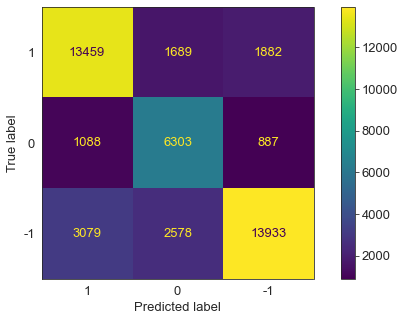

In [237]:
sns.set_style("white")
print("Whole Dataset Confusion Matrix")
c_matrix = confusion_matrix(sentiments_true_whole, sentiments_pred_whole)
ConfusionMatrixDisplay(c_matrix, display_labels=SENTIMENTS_DICT.keys()).plot()

SentiPivot Test Dataset Confusion Matrix


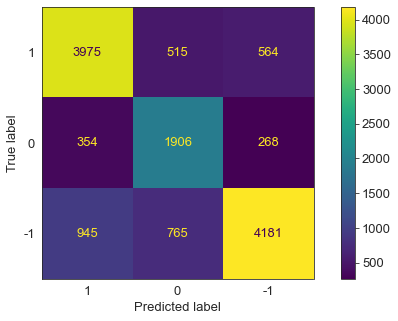

In [238]:
sns.set_style("white")
print("SentiPivot Test Dataset Confusion Matrix")
c_matrix = confusion_matrix(sentiments_true_test, sentiments_pred_test)
ConfusionMatrixDisplay(c_matrix, display_labels=SENTIMENTS_DICT.keys()).plot()

## Affin vs Affin with SentiPivot

###  with Affin

In [239]:
aff_pred = []
aff_scores = []
for doc in tokenized_whole:
    aff_score = int(AFF.score(doc))
    aff_pred.append(convert_to_numerical_sentiment(aff_score))
    aff_scores.append(aff_score)

In [240]:
aff_df = pd.DataFrame({"score":aff_scores, "sentiment":[SENTIMENTS_DICT[s] for s in aff_pred]})
aff_df.head()

,score,sentiment
0,0,Neutral
1,0,Neutral
2,-2,Negative
3,-1,Negative
4,0,Neutral


In [241]:
aff_df.to_csv(AFF_RES, index=True)

Affin Whole Dataset Confusion Matrix


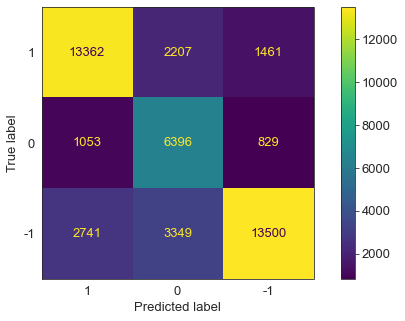

In [242]:
sns.set_style("white")
print("Affin Whole Dataset Confusion Matrix")
c_matrix = confusion_matrix(sentiments_true_whole, aff_pred)
ConfusionMatrixDisplay(c_matrix, display_labels=SENTIMENTS_DICT.keys()).plot()


### Comparison

In [243]:
def create_accuracy_bar_plot_df(model, bar_plot_scores, y_true, y_pred, overall_acc):
    bar_plot_keys = list(bar_plot_scores.keys())
    
    postive_indexes = []
    negative_indexes = []
    neutral_indexes = []
    
    for index,label in enumerate(y_true):
        if label > 0:
            postive_indexes.append(index)
        elif label < 0:
            negative_indexes.append(index)
        else:
            neutral_indexes.append(index)
            
    pos_acc = accuracy_score(np.array(y_true)[postive_indexes], np.array(y_pred)[postive_indexes]) * 100
    neg_acc = accuracy_score(np.array(y_true)[negative_indexes], np.array(y_pred)[negative_indexes]) * 100
    neu_acc = accuracy_score(np.array(y_true)[neutral_indexes], np.array(y_pred)[neutral_indexes]) * 100
    
    bar_plot_scores[bar_plot_keys[0]].extend(["Positive Accuracy", "Negative Accuracy", "Neutral Accuracy", "Overall Accuracy"])
    bar_plot_scores[bar_plot_keys[1]].extend([pos_acc, neg_acc, neu_acc, overall_acc * 100])
    bar_plot_scores[bar_plot_keys[2]].extend(np.full(4, model))
    
    return pos_acc, neg_acc, neu_acc, overall_acc

In [244]:
def create_all_scores_bar_plot_df(model, bar_plot_scores, acc, prec, rec, f1):
    bar_plot_keys = list(bar_plot_scores.keys())
    
    bar_plot_scores[bar_plot_keys[0]].extend(["Accuracy", "Precision", "Recall", "F1-Score"])
    bar_plot_scores[bar_plot_keys[1]].extend([acc * 100, prec * 100, rec * 100, f1 * 100])
    bar_plot_scores[bar_plot_keys[2]].extend(np.full(4, model))

In [245]:
methods = {
    "Affin": aff_pred,
    SENTI_PIVOT: sentiments_pred_whole
}

scores = {
    "Model":[],
    "Accuracy":[],
    "Precision":[],
    "Recall":[],
    "F1-Score":[]
}

method_acc_bar_plot_scores = {
    "Accuracy Type": [],
    "Accuracies": [],
    "Model": []
}

method_acc_table_scores = {
    "model":[],
    "Positive Accuracy":[],
    "Negative Accuracy":[],
    "Neutral Accuracy":[],
    "Overall Accuracy":[],
}


method_allscores_bar_plot_scores = {
    "Scoring": [],
    "Scores": [],
    "Model": []
}

In [246]:
for method in list(methods.keys()):
    prediction = methods[method]
    scores["Model"].append(method)
    
    accuracy = accuracy_score(sentiments_true_whole, prediction)
    precision = precision_score(sentiments_true_whole, prediction, average=SCORE_AVERAGING)
    recall = recall_score(sentiments_true_whole, prediction, average=SCORE_AVERAGING)
    f1 = f1_score(sentiments_true_whole, prediction, average=SCORE_AVERAGING)
    
    scores["Accuracy"].append(accuracy)
    scores["Precision"].append(precision)
    scores["Recall"].append(recall)
    scores["F1-Score"].append(f1)
    
    pos, neg, neu, oall = create_accuracy_bar_plot_df(method, method_acc_bar_plot_scores, sentiments_true_whole, prediction, accuracy)
    create_all_scores_bar_plot_df(method, method_allscores_bar_plot_scores, accuracy, precision, recall, f1)
    
    method_acc_table_scores["model"].append(method)
    method_acc_table_scores["Positive Accuracy"].append(pos)
    method_acc_table_scores["Negative Accuracy"].append(neg)
    method_acc_table_scores["Neutral Accuracy"].append(neu)
    method_acc_table_scores["Overall Accuracy"].append(oall)

In [247]:
method_comparison_df = pd.DataFrame(scores)
method_comparison_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Affin,0.740746,0.722988,0.748798,0.725732
1,SentiPivot,0.750479,0.731370,0.754319,0.737791


In [248]:
method_accuracy_df = pd.DataFrame(method_acc_table_scores)
method_accuracy_df

,model,Positive Accuracy,Negative Accuracy,Neutral Accuracy,Overall Accuracy
0,Affin,68.912711,78.461538,77.26504,0.740746
1,SentiPivot,71.123022,79.031122,76.14158,0.750479


In [249]:
method_comparison_df.to_csv(AFFIN_VS_SPIVOT_COMPARISON_FILE,  index=False)
method_accuracy_df.to_csv(AFFIN_VS_SPIVOT_ACCURACY_FILE, index=False)

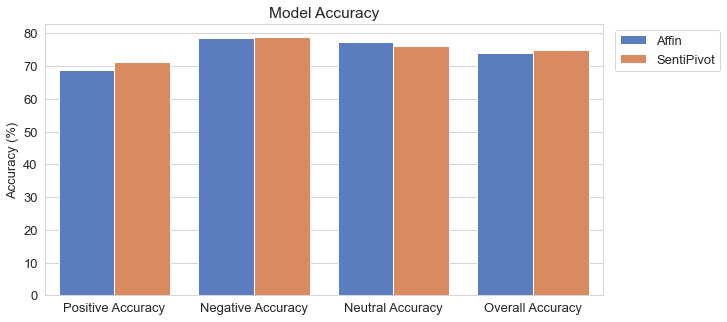

In [250]:
sns.set_style("whitegrid")
method_bar_plot = sns.barplot(x="Accuracy Type", y="Accuracies", hue="Model", palette=VISUAL_PALETTE, data=method_acc_bar_plot_scores) 
method_bar_plot.set_title("Model Accuracy")
method_bar_plot.set(ylabel='Accuracy (%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2)

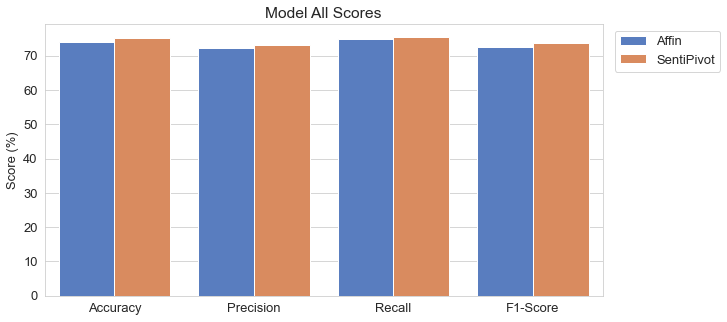

In [251]:
sns.set_style("whitegrid")
method_bar_plot = sns.barplot(x="Scoring", y="Scores", hue="Model", palette=VISUAL_PALETTE, data=method_allscores_bar_plot_scores) 
method_bar_plot.set_title("Model All Scores")
method_bar_plot.set(ylabel='Score (%)')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2)

## Other Models

In [252]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [253]:
def convert_to_aff_score(X, feature_names):
    rows = []
    cols = []
    data = []
  
    for row, x in enumerate(X):
        features_dict = dict.fromkeys(feature_names, 0)
        tokenized = x.split()
        for token in tokenized:
            try:
                features_dict[token]+= AFF.score(token)
            except KeyError:
                pass

        for feature_index, feature_name in enumerate(list(features_dict.keys())):
            score = features_dict[feature_name]
            if score != 0:
                rows.append(row)
                cols.append(feature_index)
                data.append(score)   
    
    return csr_matrix((data,(rows,cols)), (len(X), len(feature_names)))

### Prepare inputs

In [254]:
# Get feature names
cv = CountVectorizer(ngram_range=(1,1))
cv.fit_transform(tokenized_train)
feature_names= cv.get_feature_names_out()

In [255]:
# Convert features to affin sentiment score
X_train_sparse = convert_to_aff_score(tokenized_train, feature_names)
X_test_sparse = convert_to_aff_score(tokenized_test, feature_names)

### Classification

In [256]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=RAND_STATE),
    "KNeighbors": KNeighborsClassifier(),
    SENTI_PIVOT: "",
    "SVC": SVC(random_state=RAND_STATE),
    "Random Forest":RandomForestClassifier(random_state=RAND_STATE),
}

In [257]:
scores = {
    "Model":[],
    "Accuracy":[],
    "Precision":[],
    "Recall":[],
    "F1-Score":[]
}

model_bar_plot_scores = {
    "Accuracy Type": [],
    "Accuracies": [],
    "Model": []
}
model_allscores_bar_plot_scores = {
    "Scoring": [],
    "Scores": [],
    "Model": []
}

model_acc_table_scores = {
    "model":[],
    "Positive Accuracy":[],
    "Negative Accuracy":[],
    "Neutral Accuracy":[],
    "Overall Accuracy":[]
}
other_model_confusion_matrices = {}

In [258]:
# Train test other models
for model_name in list(models.keys()):
    model = models[model_name]
    print(model_name, " ...")
    
    if model_name == SENTI_PIVOT: 
        pred = sentiments_pred_test
        
    else:
        model.fit(X_train_sparse, sentiments_true_train)
        pred = model.predict(X_test_sparse)
        
    accuracy =  accuracy_score(sentiments_true_test, pred)
    precision = precision_score(sentiments_true_test, pred, average=SCORE_AVERAGING)
    recall = recall_score(sentiments_true_test, pred, average=SCORE_AVERAGING)
    f1 = f1_score(sentiments_true_test, pred, average=SCORE_AVERAGING)
    
    scores["Model"].append(model_name)
    scores["Accuracy"].append(accuracy)
    scores["Precision"].append(precision)
    scores["Recall"].append(recall)
    scores["F1-Score"].append(f1)

    other_model_confusion_matrices[model_name] = confusion_matrix(sentiments_true_test, pred)
    pos, neg, neu, oall = create_accuracy_bar_plot_df(model_name, model_bar_plot_scores, sentiments_true_test, pred, accuracy)
    create_all_scores_bar_plot_df(model_name, model_allscores_bar_plot_scores, accuracy, precision, recall, f1)
    
    model_acc_table_scores["model"].append(model_name)
    model_acc_table_scores["Positive Accuracy"].append(pos)
    model_acc_table_scores["Negative Accuracy"].append(neg)
    model_acc_table_scores["Neutral Accuracy"].append(neu)
    model_acc_table_scores["Overall Accuracy"].append(oall)

Decision Tree  ...
KNeighbors  ...
SentiPivot  ...
SVC  ...
Random Forest  ...


### Confusion Matrices

Decision Tree Confusion Matrix


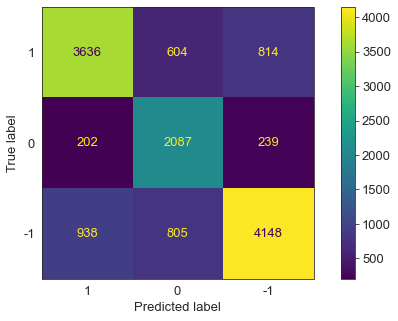

KNeighbors Confusion Matrix


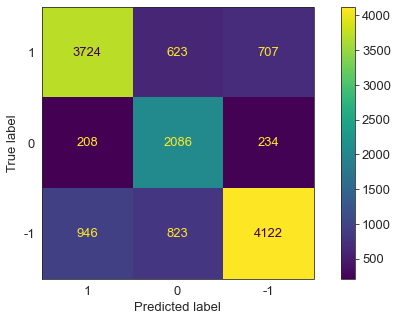

SentiPivot Confusion Matrix


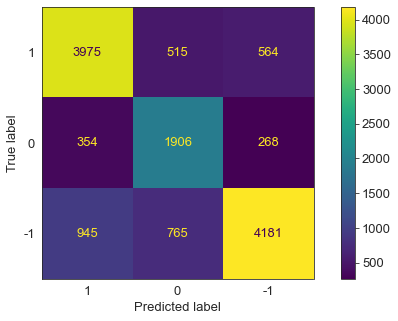

SVC Confusion Matrix


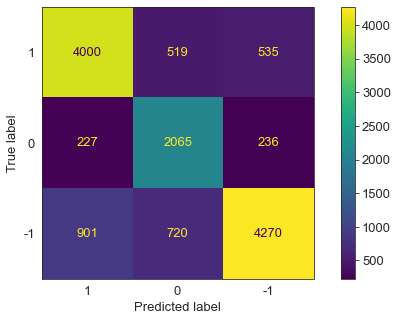

Random Forest Confusion Matrix


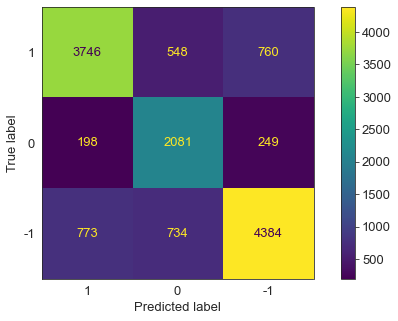

In [259]:
sns.set_style("white")
for model_name in list(other_model_confusion_matrices.keys()):
    print("{} Confusion Matrix".format(model_name))
    matrix = other_model_confusion_matrices[model_name]
    ConfusionMatrixDisplay(matrix, display_labels=SENTIMENTS_DICT.keys()).plot()
    plt.show()

## Model Comparisons

In [260]:
model_comp_df = pd.DataFrame(scores)
model_comp_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.732650,0.718604,0.749703,0.726866
1,KNeighbors,0.737178,0.722723,0.753904,0.730317
2,SentiPivot,0.746827,0.728657,0.750063,0.734587
3,SVC,0.767090,0.750695,0.777713,0.758352
4,Random Forest,0.757886,0.741949,0.769521,0.750097


In [261]:
model_accuracy_df = pd.DataFrame(model_acc_table_scores)
model_accuracy_df

,model,Positive Accuracy,Negative Accuracy,Neutral Accuracy,Overall Accuracy
0,Decision Tree,70.412494,71.943015,82.555380,0.732650
1,KNeighbors,69.971142,73.684211,82.515823,0.737178
2,SentiPivot,70.972670,78.650574,75.395570,0.746827
3,SVC,72.483449,79.145231,81.685127,0.767090
4,Random Forest,74.418605,74.119509,82.318038,0.757886


In [262]:
model_comp_df.to_csv(MODEL_COMPARISONS_FILE, index=False)
model_accuracy_df.to_csv(MODEL_ACCURACY_FILE, index=False)

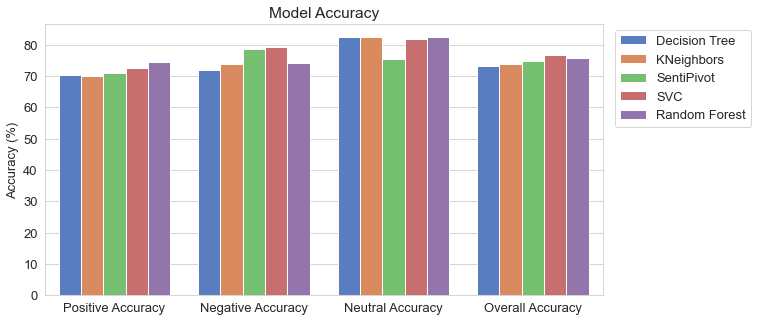

In [263]:
sns.set_style("whitegrid")
model_accuracy_bar_plot = sns.barplot(x="Accuracy Type", y="Accuracies", hue="Model", palette=VISUAL_PALETTE, data=model_bar_plot_scores) 
model_accuracy_bar_plot.set_title("Model Accuracy")
model_accuracy_bar_plot.set(ylabel='Accuracy (%)' )
plt.legend(bbox_to_anchor=(1.01, 1), loc=2)

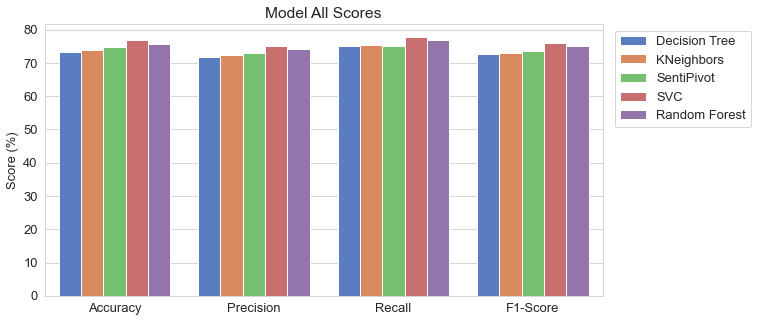

In [264]:
sns.set_style("whitegrid")
model_accuracy_bar_plot = sns.barplot(x="Scoring", y="Scores", hue="Model", palette=VISUAL_PALETTE, data=model_allscores_bar_plot_scores) 
model_accuracy_bar_plot.set_title("Model All Scores")
model_accuracy_bar_plot.set(ylabel='Score (%)' )
plt.legend(bbox_to_anchor=(1.01, 1), loc=2)